In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qutip.qip.operations as oper

from numpy import pi
from qutip.qip.circuit import QubitCircuit, Gate

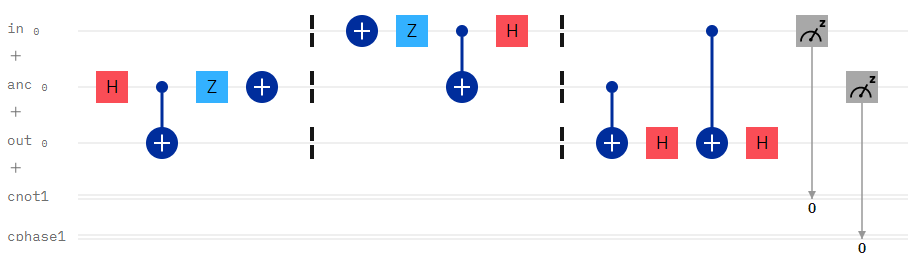

In [2]:
def initialize(state):
    bellPhi = qt.bell_state('11')
    return qt.tensor(state, bellPhi)

def evolute(state):
    CNOT01 = Gate('CNOT', targets=1, controls=0)
    CNOT12 = Gate('CNOT', targets=2, controls=1)
    CNOT02 = Gate('CNOT', targets=2, controls=0)

    H0 = Gate('SNOT', targets=0)
    sqrtX0 = Gate('SQRTNOT', targets=0)
    H2 = Gate('SNOT', targets=2)

    qc = QubitCircuit(N=3)
    
    qc.add_gate(sqrtX0)
    qc.add_gate(sqrtX0)
    qc.add_gate(H0)
    qc.add_gate(sqrtX0)
    qc.add_gate(sqrtX0)
    qc.add_gate(H0)
    
    qc.add_gate(CNOT01)
    qc.add_gate(H0)
  
    gates_sequence = qc.propagators()
    scheme = oper.gate_sequence_product(gates_sequence)
    return scheme * state
    

def measure(state):
    rho0 = state.ptrace(0) # МП 1-го кубита
    rho1 = state.ptrace(1) # МП 2-го кубита
    
    rho01 = state.ptrace([0,1])
    P = rho01.diag()
    result = np.random.choice([0, 1, 2, 3], p=P)
    
    return result
    
twoQ_basis = {0: '00', 1: '01', 2: '10', 3: '11'}

def teleport(state, mres):
    q0, q1 = map(int, twoQ_basis[mres])
    
    s0_name = twoQ_basis[mres] + '0'
    s1_name = twoQ_basis[mres] + '1'
    s0 = qt.bra(s0_name)
    s1 = qt.bra(s1_name)
    
    a = (s0 * state).tr()
    b = (s1 * state).tr()
    red_state = (a*qt.ket([0], 2) + b*qt.ket([1], 2)).unit()
    
    H = Gate('SNOT', targets=0)
    sqrtX = Gate('SQRTNOT', targets=0)
    qc = QubitCircuit(N=1)
    
    if q1 == 1:
        qc.add_gate(sqrtX)
        qc.add_gate(sqrtX)
    if q0 == 1:
        qc.add_gate(H)
        qc.add_gate(sqrtX)
        qc.add_gate(sqrtX)
        qc.add_gate(H)
    gates_sequence = qc.propagators()
    scheme = oper.gate_sequence_product(gates_sequence)
    
    return scheme * red_state

In [4]:
if __name__ == "__main__":
    fidelity = []
    
    for i in range(1):
        random_qubit = qt.rand_ket(2)

        in_state = initialize(random_qubit)
        out_state = evolute(in_state)
        mres = measure(out_state)
        t_state = teleport(out_state, mres)

#         f = qt.fidelity(t_state, random_qubit)
#         fidelity.append(f)
        
#     plt.hist(fidelity)
#     plt.show()